In [4]:
import pandas as pd
from fasttext import train_supervised

# データセット解凍・読み込み

用いるデータセットは14のクラスに対するテキストを均等に含むデータで, 学習データ560,000件, テストデータ70,000件である.

In [2]:
!tar -xvf data/dbpedia_csv.tar.gz -C data

dbpedia_csv/
dbpedia_csv/test.csv
dbpedia_csv/classes.txt
dbpedia_csv/train.csv
dbpedia_csv/readme.txt


In [6]:
data_path = "data"

train_file = data_path+"/dbpedia_csv/train.csv"
df = pd.read_csv(train_file,header=None,names=["class","name","description"])

test_file = data_path+"/dbpedia_csv/test.csv"
df_test = pd.read_csv(test_file,header=None,names=["class","name","description"])

print(df.shape,df_test.shape)

(560000, 3) (70000, 3)


In [7]:
df.head()

,class,name,description
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


# 前処理

In [8]:
# 各クラスの意味
class_dict={
    1: 'Company',
    2: 'EducationalInstitution',
    3: 'Artist',
    4: 'Athlete',
    5: 'OfficeHolder',
    6: 'MeanOfTransportation',
    7: 'Building',
    8: 'NaturalPlace',
    9: 'Village',
    10: 'Animal',
    11: 'Plant',
    12: 'Album',
    13: 'Film',
    14: 'WrittenWork'
}

df["class_name"] = df["class"].map(class_dict) 
df.head()

,class,name,description,class_name
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...,Company
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...,Company
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...,Company
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...,Company
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...,Company


In [9]:
df["class_name"].value_counts()

Company                   40000
EducationalInstitution    40000
Artist                    40000
Athlete                   40000
OfficeHolder              40000
MeanOfTransportation      40000
Building                  40000
NaturalPlace              40000
Village                   40000
Animal                    40000
Plant                     40000
Album                     40000
Film                      40000
WrittenWork               40000
Name: class_name, dtype: int64

In [10]:
def clean_it(text,normalize=True):
    # 文字の置き換え
    s = str(text)\
            .replace(',', ' ')\
            .replace('"', '')\
            .replace('\'', ' \' ')\
            .replace('.', ' . ')\
            .replace('(', ' ( ')\
            .replace(')', ' ) ')\
            .replace('!', ' ! ')\
            .replace('?', ' ? ')\
            .replace(':', ' ')\
            .replace(';', ' ')\
            .lower()
    if normalize:
        # 正規化
        s = s.normalize("NFKD").str.encode("ascii","ignore").str.decode("utf-8")
        
    return s

def clean_df(data,cleanit=False,shuffleit=False,encodeit=False,label_prefix="__class__"):
    df = data[["name","description"]].copy(deep=True)
    df["class"] = label_prefix+data["class"].astype(str)+" "
    
    if cleanit:
        df['name'] = df['name'].apply(lambda x: clean_it(x, encodeit))
        df['description'] = df['description'].apply(lambda x: clean_it(x, encodeit))
        
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)
    
    return df

In [11]:
df_train_cleaned = clean_df(df, True, True)
df_test_cleaned = clean_df(df_test, True, True)

In [12]:
df_train_cleaned = df_train_cleaned.sample(frac=1, random_state=0)
df_test_cleaned = df_test_cleaned.sample(frac=1, random_state=0)

In [14]:
df_train_cleaned.head()

,name,description,class
245601,waterways experiment station,the waterways experiment station also known a...,__class__7
252469,ibm building ( seattle ),the ibm building is a 20-story skyscraper in ...,__class__7
227560,royal enfield fury,the royal enfield fury is a british motorcycl...,__class__6
144727,andrés gómez,andrés gómez santos ( born february 27 1960 ...,__class__4
196076,nita deerpalsing,kumaree rajeshree deerpalsing mp ( born नीता...,__class__5


In [15]:
# クリーニングしたデータを保存
train_file = data_path + '/dbpedia_train.csv'
test_file = data_path + '/dbpedia_test.csv'

columns = ['class', 'name', 'description']
df_train_cleaned.to_csv(
    train_file,
    header=None,
    index=False,
    columns=columns
)
df_test_cleaned.to_csv(
    test_file,
    header=None,
    index=False,
    columns=columns
)

In [16]:
!head data/dbpedia_train.csv

__class__7 ,waterways experiment station, the waterways experiment station also known as wes-original cantonment in vicksburg mississippi is a sprawling 673-acre  ( 272 ha )  complex built in 1930 as an united states army corps of engineers research facility .  its campus is the site of the headquarters of the engineer research and development center  ( erdc )  of the corps of engineers .  wes is the largest of the four corps of engineers '  research and development laboratories .  the facility was listed on the u . s . 
__class__7 ,ibm building  ( seattle ) , the ibm building is a 20-story skyscraper in the metropolitan tract at 1200 fifth avenue seattle washington .  the building was designed by minoru yamasaki who also was architect of rainier tower on the corner diagonally opposite and the world trade center in new york city . 
__class__6 ,royal enfield fury, the royal enfield fury is a british motorcycle made by royal enfield at their factory in redditch .  the fury name has also 

# モデリング

In [18]:
model = train_supervised(input = train_file,
                        label="__class__",
                        lr=0.1,
                        dim=10,
                        epoch=5,
                        wordNgrams=2,
                        seed=0)

Read 31M words
Number of words:  1116962
Number of labels: 14
Progress: 100.0% words/sec/thread: 3068616 lr:  0.000000 avg.loss:  0.092851 ETA:   0h 0m 0s100.0% words/sec/thread: 3068671 lr: -0.000000 avg.loss:  0.092851 ETA:   0h 0m 0s


In [19]:
for k in range(1,6):
    results = model.test(test_file, k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 70000 Precision@1 : 98.4171 Recall@1 : 98.4171
Test Samples: 70000 Precision@2 : 49.8207 Recall@2 : 99.6414
Test Samples: 70000 Precision@3 : 33.2800 Recall@3 : 99.8400
Test Samples: 70000 Precision@4 : 24.9754 Recall@4 : 99.9014
Test Samples: 70000 Precision@5 : 19.9877 Recall@5 : 99.9386


In [20]:
model.save_model("model.bin")

In [21]:
!ls -lh model.bin

-rw-r--r-- 1 root root 140M Mar  8 16:07 model.bin


# ロジスティック回帰による分類器の作成

学習済み単語埋め込みとして上で作成したfastTextのものを用いる. 用いるデータはword2vec_text_classification.ipynbと同じ. 

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from string import punctuation
import fasttext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
data_path = "data"
model_path = "model.bin"
training_data_path = os.path.join(data_path,"sentiment_sentences.txt")
# 自分で作成したモデルを読み込み
w2v_model = fasttext.load_model(model_path)
print('done loading Word2Vec')

# テキストデータとカテゴリの読み取り
texts = []
cats = []
fh = open(training_data_path)
for line in fh:
    text, sentiment = line.split("\t")
    texts.append(text)
    cats.append(sentiment)

done loading Word2Vec


In [44]:
# データセットの確認
print(len(cats), len(texts))
print(texts[1])
print(cats[1])

3000 3000
Good case, Excellent value.
1



## 前処理

In [45]:
# テキストの前処理
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        # 小文字化、ストップワードと数字の除去
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

texts_processed = preprocess_corpus(texts)
print(len(cats), len(texts_processed))
print(texts_processed[1])
print(cats[1])

3000 3000
['good', 'case', 'excellent', 'value']
1



In [47]:
# 文に含まれる単語の埋め込みを平均して、特徴ベクトルを作成
def embedding_feats(list_of_lists):
    DIMENSION = 10
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens: # tokensに含まれる1単語ずつに対して
            if token in w2v_model: # モデルに単語が存在
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if count_for_this:
          feats.append(feat_for_this / count_for_this)
        else:
          feats.append(feat_for_this)
    return feats


train_vectors = embedding_feats(texts_processed)
print(len(train_vectors))

3000


## モデリング

In [48]:
logreg = LogisticRegression(random_state=1234)
train_data,test_data,train_cats,test_cats = train_test_split(train_vectors,cats)
logreg.fit(train_data,train_cats)
y_pred_cats = logreg.predict(test_data)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

Accuracy:  0.5533333333333333


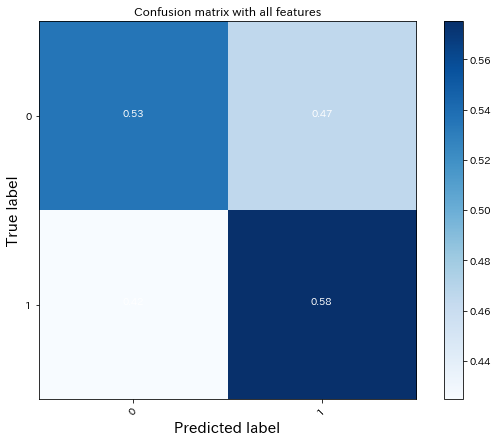

In [50]:
# 正解率
print("Accuracy: ", accuracy_score(test_cats, y_pred_cats))

    
# 混同行列
cnf_matrix = confusion_matrix(test_cats, y_pred_cats)
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,
    classes=['0', '1'],
    normalize=True,
    title='Confusion matrix with all features'
)